<a href="https://colab.research.google.com/github/gulabpatel/Knowledge_Distillation/blob/main/2_tf_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
len(X_train)

60000

In [4]:
len(X_test)

10000

In [5]:
X_train[0].shape

(28, 28)

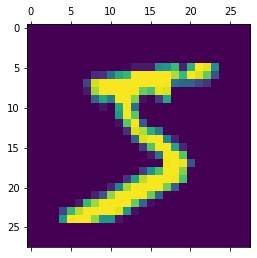

In [6]:
plt.matshow(X_train[0])

In [7]:
y_train[0]

5

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [10]:
X_train_flattened.shape

(60000, 784)

<h3 style='color:purple'>Using Flatten layer so that we don't have to call .reshape on input dataset</h3>

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2725 - accuracy: 0.9226
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1221 - accuracy: 0.9646
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0852 - accuracy: 0.9749
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0654 - accuracy: 0.9803
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0519 - accuracy: 0.9840


In [12]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0823 - accuracy: 0.9751


[0.08228962123394012, 0.9750999808311462]

In [13]:
model.save("./saved_model/")

<h3 style='color:blue'>(1) Post training quantization</h3>

**Without quantization**

In [14]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

**With quantization**

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [16]:
len(tflite_model)

319944

In [17]:
len(tflite_quant_model)

84816

You can see above that quantizated model is 1/4th the size of a non quantized model

In [18]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [19]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

Once you have above files saved to a disk, check their sizes. Quantized model will be obvi

<h3 style='color:blue'>(2) Quantization aware training</h3>

In [ ]:
!pip install tensorflow_model_optimization

In [22]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [23]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 16s 8ms/step - loss: 0.0446 - accuracy: 0.9858


In [24]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0784 - accuracy: 0.9745


[0.07837896049022675, 0.9745000004768372]

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [26]:
len(tflite_qaware_model)

82672

In [27]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)